In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt

from lab2_tools import *
from lab2_proto import *

In [2]:
data = np.load('lab2_data.npz', allow_pickle=True)['data']
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()

# The variable data and example are arrays of dictionaries. Each element contains the following keys:

# filename: filename of the wave file in the database
# samplingrate: sampling rate of the speech signal (20kHz in all examples) 
# gender: gender of the speaker for the current utterance (man, woman) 
# speaker: speaker ID for the current utterance (ae, ac)
# digit: digit contained in the current utterance (o, z, 1, ..., 9) 
# repetition: whether this was the first (a) or second (b) repetition
# samples: array of speech samples
# lmfcc: liftered Mel Frequency Cepstrum Coefficients
# ----------------------- For example only -----------------------
# obsloglik: observation log likelihood for each Gaussian in wordHMMs['o'], shape: (n_timesteps, n_states)
# logalpha: alpha log probabilities, see definition later, shape: (n_timesteps, n_states)
# logbeta: beta log probabilities, see definition later, shape: (n_timesteps, n_states)
# loglik: log likelihood of the observations sequence X given the HMM model, scalar
# vloglik: Viterbi log likelihood of the observations se- quence X and the best path given the HMM model, scalar
# loggamma: gamma log probabilities, see definition later, shape: (n_timesteps, n_states)
# logxi: xi log probabilities, see definition later, shape: (n_timesteps, n_states)

In [3]:
# trained on the full training set
phoneHMMs = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()

# trained on a single speaker, that happens to be female
# phoneHMMs = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()

# phoneHMMs is a dictionary with 21 keys, each corresponding to a phonetic model
list(sorted(phoneHMMs.keys()))

['ah',
 'ao',
 'ay',
 'eh',
 'ey',
 'f',
 'ih',
 'iy',
 'k',
 'n',
 'ow',
 'r',
 's',
 'sil',
 'sp',
 't',
 'th',
 'uw',
 'v',
 'w',
 'z']

In [4]:
phoneHMMs['ah'].keys()
# name: phonetic symbol, sil(silence) or sp(short pauses)
# startprob: probability to start in state i, size: [4,]
# transmat: transition probability from state i to j, size: [4, 4]
# means: [3, 13] array of mean vectors (rows correspond to different states)
# covars: [3, 13] array of variance vectors (rows correspond to different states)

dict_keys(['name', 'startprob', 'transmat', 'means', 'covars'])

In [5]:
from prondict import *

# Because we are working with recordings of isolated digits, 
# a model of each utterance should also contain initial and final silence
isolated = {}
wordHMMs = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']
    wordHMMs[digit] = concatHMMs(phoneHMMs, isolated[digit])

# Gaussian emission probabilities

obsloglik is checked


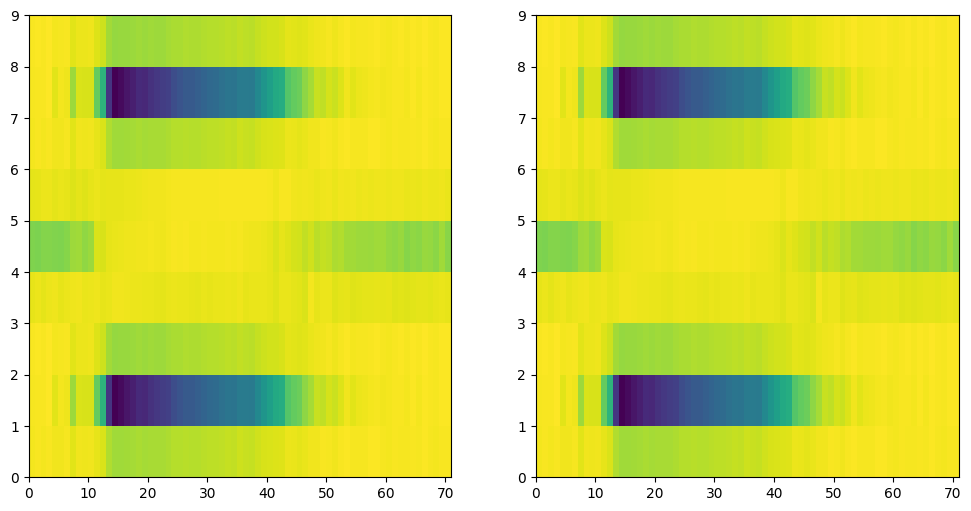

In [6]:
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])  
if np.allclose(obsloglik, example["obsloglik"]):
    print("obsloglik is checked")

plt.figure(figsize=(12, 6)) 
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.pcolormesh(obsloglik.T)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.pcolormesh(example['obsloglik'].T)
plt.show()

# Forward Algorithm

logalpha is checked


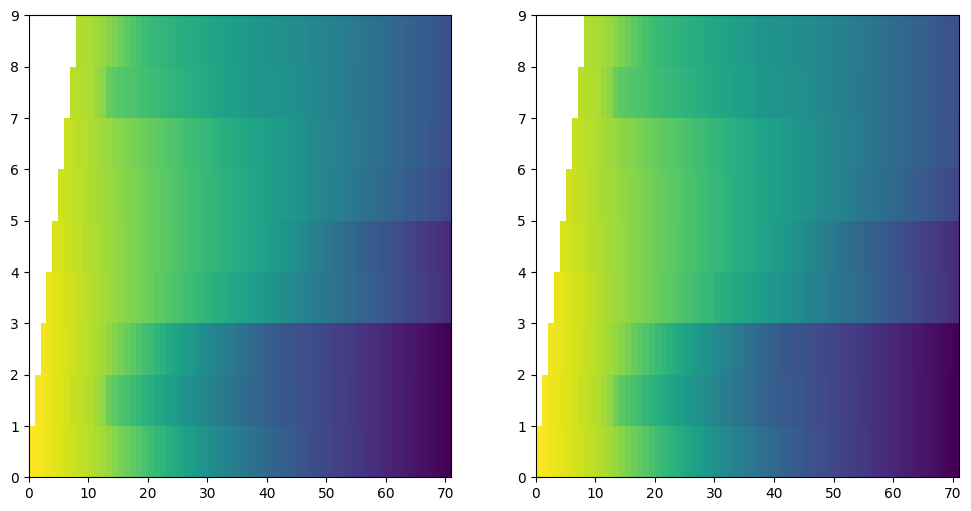

In [7]:
log_startprob = np.log(wordHMMs['o']['startprob'][:-1])
log_transmat = np.log(wordHMMs['o']['transmat'][:-1, :-1])
logalpha = forward(obsloglik, log_startprob, log_transmat) 
if np.allclose(logalpha, example["logalpha"]):
    print("logalpha is checked")

plt.figure(figsize=(12, 6)) 
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.pcolormesh(logalpha.T)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.pcolormesh(example['logalpha'].T)
plt.show()

In [8]:
# last coloum in logalpha gives all observations 
loglik = logsumexp(logalpha[-1])
if np.allclose(loglik, example["loglik"]):
    print("loglik is checked")

loglik is checked


# Viterbi Approximation

In [9]:
vloglik, vpath = viterbi(obsloglik, log_startprob, log_transmat)

if np.allclose(vloglik, example['vloglik']):
    print("vloglik is checked")
if np.allclose(vpath, example['vpath']):
    print("vpath is checked")

vloglik is checked
vpath is checked


# Backward Algorithm

logbeta is checked


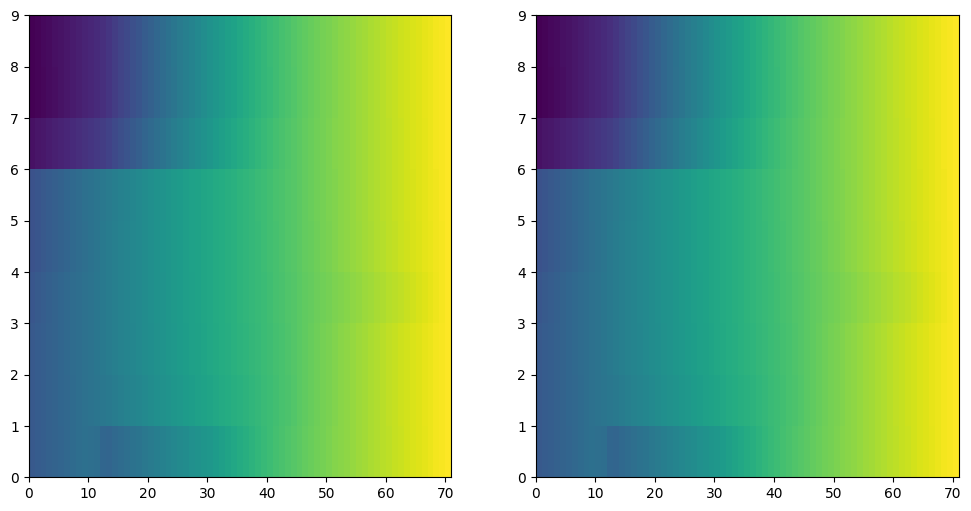

In [10]:
logbeta = backward(obsloglik, log_startprob, log_transmat) 
if np.allclose(logbeta, example["logbeta"]):
    print("logbeta is checked")

plt.figure(figsize=(12, 6)) 
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.pcolormesh(logbeta.T)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.pcolormesh(example['logbeta'].T)
plt.show()